# Ignis T<sub>1</sub> Tests

> 5/10/19

In this document, I'd like to use the shiny new (I believe just released this March) Qiskit Ignis to re-run the T<sub>1</sub> tests. (As a random side note, there is a typo on the main Ignis page...I wonder if they'd appreciate a pull request to fix it.) Apparently, this module includes a function to generate the very tests IBM uses!

In [1]:
# import quantum libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.ignis.characterization.coherence as ig
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

In [2]:
# snippet: wrapper to execute some circuit(s)
# this snippet depends on the quantum imports snippet
# parameters:
#   circuit: a single qiskit.QuantumCircuit or a list of them
#   shots, max_credits: self-explanatory
#   qubits: number of qubits needed (only necessary for auto-backend)
#   backend: either None (auto-choose leasy busy) or qiskit.IBMQBackend
#   opt: make circuit optimizations
# returns:
#   job: the job that ran
#   backend: the backend used
#   circuit: the circuit(s) used (for reproducibility)
def run(circuit, shots=1024, max_credits=10, qubits=5, backend=None, opt=True):

    if backend is None:
        # get least busy backend if not specified
        available = q.IBMQ.backends(filters=lambda x:
                                    x.configuration().n_qubits >= qubits
                                    and not
                                    x.configuration().simulator)
        backend = q.providers.ibmq.least_busy(available)

    manager = None
    if not opt:
        # disable optimization by adding a dummy pass manager
        manager = q.tools.compiler.PassManager()

    # execute job
    job = q.execute(circuit, backend=backend, shots=shots,
                    max_credits=max_credits, pass_manager=manager)
    monitor.job_monitor(job)

    # print job info for later retrieval if necessary
    print('Job ID \'%s\'' % job.job_id())
    print('Ran on backend \'%s\'' % backend.name())
    print('Completed %s' % job.creation_date())

    return job, backend, circuit

In [3]:
# snippet: retrieve an old qiskit job from job id and backend name
def get_job(job_id, backend_name):
    backend = q.IBMQ.get_backend(backend_name)
    return backend.retrieve_job(job_id)

Now let's construct some nice circuits. Since I'm new to this module, I'll mostly be following the documentation.

[  0.   9.  18.  27.  36.  45.  54.  63.  72.  81.  90.  99. 108. 117.
 126. 135. 144. 153. 162. 171. 180. 189. 198. 207. 216.]


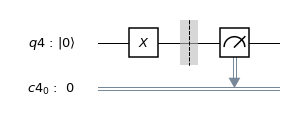

In [12]:
# gate time data from https://quantumexperience.ng.bluemix.net/qx/community/question?questionId=5ae975670f020500399ed29e&answerId=5ae975730f020500399ee154
# also see https://github.com/Qiskit/ibmq-device-information/blob/master/backends/tenerife/V1/version_log.md
qubits = [0]
circuits, delays = ig.circuits.t1_circuits(num_of_gates=np.arange(0, 2250, 90), gate_time=0.08333, qubits=qubits)
print(delays)
circuits[0].draw(output='mpl')

In [13]:
job, backend, _ = run(circuits, qubits=len(qubits))

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5cd5d26356c7a3006f9cc038'
Ran on backend 'ibmqx4'
Completed 2019-05-10T19:34:58.090Z


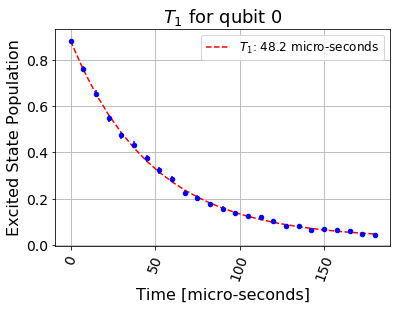

In [49]:
# get job like this for easier reproducibility later
job = get_job('5cd5d26356c7a3006f9cc038', 'ibmqx4')
delays = np.arange(0, 2250, 90) * 0.08333
fit = ig.fitters.T1Fitter(job.result(), delays, qubits, fit_p0=[1, 10, 0], fit_bounds=([0, 0, -1], [2, 80, 1]))
for i in qubits:
    fit.fit_data(i)
    fit.plot(i)

Hey, that's pretty good! For two-year-old gate time data, 48.2 μs is remarkably close to the 46.8 μs posted as the latest official calibration value on the IBM Q Experience website. (Though it's a little further from the 42.7 μs returned by `q.IBMQ.get_backend('ibmqx4').properties().qubits[0]`.) I'm not sure how I can get more updated values for the gate timings.

There seems to be a document on [Github](https://github.com/Qiskit/ibmq-device-information/blob/master/backends/tenerife/V1/version_log.md) that lists some "GD" gate times from 4/19, but there's no indication of how they measured them or what "GD" means (and I'm not sure what the delay between pulses is). If I use ~70 ns, as the document suggests, I get a T<sub>1</sub> of around 40 μs, which is extremely close to 42.7 μs.